# Creating Chat Bots

## Load the data

In [25]:
import pickle
import numpy as np

In [26]:
with open("train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp)

In [27]:
with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

## EDA

In [28]:
type(train_data)

list

In [29]:
type(test_data)

list

In [30]:
len(train_data)

10000

In [31]:
len(test_data)

1000

In [32]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [33]:
train_data[0][0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [34]:
train_data[0][1]

['Is', 'Sandra', 'in', 'the', 'hallway', '?']

In [35]:
train_data[0][2]

'no'

## Create a vocabulary of all data

In [36]:
# Create a set that holds the vocab words
vocab = set()

In [37]:
all_data = test_data + train_data

In [38]:
len(all_data)

11000

In [39]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [40]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went'}

In [41]:
vocab.add('no')
vocab.add('yes')

In [42]:
vocab_len = len(vocab) + 1

In [43]:
max_story_len = max([len(data[0]) for data in all_data])

In [44]:
max_question_len = max([len(data[1]) for data in all_data])

In [45]:
max_question_len

6

## Vectorizing the data

In [46]:
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [47]:
# integer encode sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [48]:
tokenizer.word_index

{'milk': 1,
 'grabbed': 2,
 'journeyed': 3,
 'office': 4,
 'is': 5,
 'put': 6,
 'went': 7,
 'football': 8,
 'daniel': 9,
 'bedroom': 10,
 '?': 11,
 'no': 12,
 'mary': 13,
 'apple': 14,
 'travelled': 15,
 'down': 16,
 'left': 17,
 'got': 18,
 'picked': 19,
 'john': 20,
 'in': 21,
 'up': 22,
 'there': 23,
 'took': 24,
 'yes': 25,
 'dropped': 26,
 '.': 27,
 'bathroom': 28,
 'kitchen': 29,
 'discarded': 30,
 'the': 31,
 'hallway': 32,
 'garden': 33,
 'sandra': 34,
 'moved': 35,
 'to': 36,
 'back': 37}

In [49]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [50]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [51]:
len(train_story_seq)

10000

In [52]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [53]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [54]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [55]:
tokenizer.word_index['yes']

25

In [56]:
tokenizer.word_index['no']

12

## Creating Model

In [57]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [58]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

### Input Encoder m

In [60]:
vocab_size = len(vocab) + 1

In [61]:
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))
# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### Input Encoder C

In [62]:
# Input gets embedded to a sequence of vectors
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

### Question Encoder

In [63]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

### Encode the Sequences

In [64]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [65]:
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [66]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [67]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [68]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)  # (samples, 32)

In [69]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)

In [70]:
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_3 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [101]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=1000,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/1000
313/313 [==============================] - 4s 14ms/step - loss: 1.7575 - accuracy: 0.4661 - val_loss: 0.6962 - val_accuracy: 0.5050
Epoch 2/1000
313/313 [==============================] - 6s 19ms/step - loss: 0.7026 - accuracy: 0.5150 - val_loss: 0.6906 - val_accuracy: 0.5350
Epoch 3/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.6926 - accuracy: 0.5318 - val_loss: 0.6819 - val_accuracy: 0.5900
Epoch 4/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.6863 - accuracy: 0.5544 - val_loss: 0.6687 - val_accuracy: 0.5930
Epoch 5/1000
313/313 [==============================] - 7s 22ms/step - loss: 0.6672 - accuracy: 0.5910 - val_loss: 0.6397 - val_accuracy: 0.6540
Epoch 6/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.6542 - accuracy: 0.6108 - val_loss: 0.6126 - val_accuracy: 0.6800
Epoch 7/1000
313/313 [==============================] - 7s 22ms/step - loss: 0.6352 - accuracy: 0.6492 - val_loss: 0.5864 - val_ac

313/313 [==============================] - 7s 23ms/step - loss: 0.3033 - accuracy: 0.8660 - val_loss: 0.3702 - val_accuracy: 0.8420
Epoch 58/1000
313/313 [==============================] - 7s 21ms/step - loss: 0.3037 - accuracy: 0.8694 - val_loss: 0.3513 - val_accuracy: 0.8410
Epoch 59/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.2995 - accuracy: 0.8694 - val_loss: 0.3648 - val_accuracy: 0.8380
Epoch 60/1000
313/313 [==============================] - 7s 21ms/step - loss: 0.3060 - accuracy: 0.8684 - val_loss: 0.3687 - val_accuracy: 0.8380
Epoch 61/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.3013 - accuracy: 0.8715 - val_loss: 0.3713 - val_accuracy: 0.8400
Epoch 62/1000
313/313 [==============================] - 7s 22ms/step - loss: 0.3052 - accuracy: 0.8662 - val_loss: 0.3553 - val_accuracy: 0.8440
Epoch 63/1000
313/313 [==============================] - 7s 21ms/step - loss: 0.2996 - accuracy: 0.8694 - val_loss: 0.3607 - val_accuracy:

313/313 [==============================] - 7s 23ms/step - loss: 0.2678 - accuracy: 0.8843 - val_loss: 0.3906 - val_accuracy: 0.8310
Epoch 114/1000
313/313 [==============================] - 7s 21ms/step - loss: 0.2643 - accuracy: 0.8887 - val_loss: 0.4463 - val_accuracy: 0.8300
Epoch 115/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.2700 - accuracy: 0.8852 - val_loss: 0.4443 - val_accuracy: 0.8220
Epoch 116/1000
313/313 [==============================] - 7s 21ms/step - loss: 0.2654 - accuracy: 0.8873 - val_loss: 0.4139 - val_accuracy: 0.8280
Epoch 117/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.2680 - accuracy: 0.8856 - val_loss: 0.4085 - val_accuracy: 0.8290
Epoch 118/1000
313/313 [==============================] - 7s 21ms/step - loss: 0.2692 - accuracy: 0.8864 - val_loss: 0.4444 - val_accuracy: 0.8330
Epoch 119/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.2685 - accuracy: 0.8900 - val_loss: 0.4019 - val_acc

Epoch 169/1000
313/313 [==============================] - 8s 24ms/step - loss: 0.2409 - accuracy: 0.8984 - val_loss: 0.4940 - val_accuracy: 0.8240
Epoch 170/1000
313/313 [==============================] - 7s 22ms/step - loss: 0.2409 - accuracy: 0.9007 - val_loss: 0.4605 - val_accuracy: 0.8340
Epoch 171/1000
313/313 [==============================] - 7s 24ms/step - loss: 0.2387 - accuracy: 0.9035 - val_loss: 0.4953 - val_accuracy: 0.8320
Epoch 172/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.2337 - accuracy: 0.9045 - val_loss: 0.4591 - val_accuracy: 0.8370
Epoch 173/1000
313/313 [==============================] - 7s 23ms/step - loss: 0.2414 - accuracy: 0.9007 - val_loss: 0.4460 - val_accuracy: 0.8330
Epoch 174/1000
313/313 [==============================] - 8s 24ms/step - loss: 0.2427 - accuracy: 0.9009 - val_loss: 0.4521 - val_accuracy: 0.8370
Epoch 175/1000
313/313 [==============================] - 7s 22ms/step - loss: 0.2267 - accuracy: 0.9078 - val_loss: 0

Epoch 225/1000
313/313 [==============================] - 8s 24ms/step - loss: 0.1907 - accuracy: 0.9274 - val_loss: 0.4780 - val_accuracy: 0.8480
Epoch 226/1000
313/313 [==============================] - 7s 24ms/step - loss: 0.1882 - accuracy: 0.9259 - val_loss: 0.4470 - val_accuracy: 0.8460
Epoch 227/1000
313/313 [==============================] - 8s 27ms/step - loss: 0.1814 - accuracy: 0.9307 - val_loss: 0.4932 - val_accuracy: 0.8340
Epoch 228/1000
313/313 [==============================] - 9s 29ms/step - loss: 0.1893 - accuracy: 0.9226 - val_loss: 0.5002 - val_accuracy: 0.8370
Epoch 229/1000
313/313 [==============================] - 8s 25ms/step - loss: 0.1875 - accuracy: 0.9273 - val_loss: 0.5061 - val_accuracy: 0.8470
Epoch 230/1000
313/313 [==============================] - 8s 24ms/step - loss: 0.1850 - accuracy: 0.9277 - val_loss: 0.5075 - val_accuracy: 0.8490
Epoch 231/1000
313/313 [==============================] - 8s 25ms/step - loss: 0.1783 - accuracy: 0.9293 - val_loss: 0

Epoch 281/1000
313/313 [==============================] - 8s 26ms/step - loss: 0.1501 - accuracy: 0.9443 - val_loss: 0.4195 - val_accuracy: 0.8640
Epoch 282/1000
313/313 [==============================] - 8s 27ms/step - loss: 0.1516 - accuracy: 0.9440 - val_loss: 0.4197 - val_accuracy: 0.8690
Epoch 283/1000
313/313 [==============================] - 8s 25ms/step - loss: 0.1410 - accuracy: 0.9456 - val_loss: 0.4558 - val_accuracy: 0.8750
Epoch 284/1000
313/313 [==============================] - 9s 28ms/step - loss: 0.1496 - accuracy: 0.9464 - val_loss: 0.3994 - val_accuracy: 0.8660
Epoch 285/1000
313/313 [==============================] - 8s 26ms/step - loss: 0.1459 - accuracy: 0.9454 - val_loss: 0.5043 - val_accuracy: 0.8640
Epoch 286/1000
313/313 [==============================] - 9s 27ms/step - loss: 0.1484 - accuracy: 0.9445 - val_loss: 0.4547 - val_accuracy: 0.8710
Epoch 287/1000
313/313 [==============================] - 8s 26ms/step - loss: 0.1402 - accuracy: 0.9474 - val_loss: 0

Epoch 337/1000
313/313 [==============================] - 9s 27ms/step - loss: 0.1265 - accuracy: 0.9564 - val_loss: 0.4076 - val_accuracy: 0.8760
Epoch 338/1000
313/313 [==============================] - 9s 30ms/step - loss: 0.1311 - accuracy: 0.9559 - val_loss: 0.4240 - val_accuracy: 0.8880
Epoch 339/1000
313/313 [==============================] - 9s 28ms/step - loss: 0.1251 - accuracy: 0.9550 - val_loss: 0.4497 - val_accuracy: 0.8830
Epoch 340/1000
313/313 [==============================] - 10s 30ms/step - loss: 0.1298 - accuracy: 0.9560 - val_loss: 0.4937 - val_accuracy: 0.8750
Epoch 341/1000
313/313 [==============================] - 9s 29ms/step - loss: 0.1186 - accuracy: 0.9581 - val_loss: 0.5004 - val_accuracy: 0.8770
Epoch 342/1000
313/313 [==============================] - 9s 30ms/step - loss: 0.1321 - accuracy: 0.9536 - val_loss: 0.4608 - val_accuracy: 0.8870
Epoch 343/1000
313/313 [==============================] - 9s 30ms/step - loss: 0.1222 - accuracy: 0.9538 - val_loss: 

313/313 [==============================] - 10s 33ms/step - loss: 0.1137 - accuracy: 0.9607 - val_loss: 0.4987 - val_accuracy: 0.8810
Epoch 393/1000
313/313 [==============================] - 10s 32ms/step - loss: 0.1075 - accuracy: 0.9614 - val_loss: 0.5480 - val_accuracy: 0.8760
Epoch 394/1000
313/313 [==============================] - 10s 31ms/step - loss: 0.1216 - accuracy: 0.9586 - val_loss: 0.5181 - val_accuracy: 0.8860
Epoch 395/1000
313/313 [==============================] - 10s 34ms/step - loss: 0.1131 - accuracy: 0.9620 - val_loss: 0.5116 - val_accuracy: 0.8750
Epoch 396/1000
313/313 [==============================] - 10s 31ms/step - loss: 0.1144 - accuracy: 0.9639 - val_loss: 0.5280 - val_accuracy: 0.8730
Epoch 397/1000
313/313 [==============================] - 10s 32ms/step - loss: 0.1107 - accuracy: 0.9657 - val_loss: 0.5805 - val_accuracy: 0.8770
Epoch 398/1000
313/313 [==============================] - 10s 32ms/step - loss: 0.1118 - accuracy: 0.9617 - val_loss: 0.4329 - 

313/313 [==============================] - 10s 32ms/step - loss: 0.1013 - accuracy: 0.9656 - val_loss: 0.5214 - val_accuracy: 0.8760
Epoch 448/1000
313/313 [==============================] - 11s 34ms/step - loss: 0.1026 - accuracy: 0.9653 - val_loss: 0.5086 - val_accuracy: 0.8770
Epoch 449/1000
313/313 [==============================] - 20s 64ms/step - loss: 0.1011 - accuracy: 0.9662 - val_loss: 0.5170 - val_accuracy: 0.8680
Epoch 450/1000
313/313 [==============================] - 14s 44ms/step - loss: 0.0988 - accuracy: 0.9680 - val_loss: 0.5827 - val_accuracy: 0.8790
Epoch 451/1000
313/313 [==============================] - 24s 76ms/step - loss: 0.1058 - accuracy: 0.9659 - val_loss: 0.5722 - val_accuracy: 0.8850
Epoch 452/1000
313/313 [==============================] - 31s 99ms/step - loss: 0.1161 - accuracy: 0.9624 - val_loss: 0.4985 - val_accuracy: 0.8740
Epoch 453/1000
313/313 [==============================] - 38s 122ms/step - loss: 0.1021 - accuracy: 0.9652 - val_loss: 0.4989 -

313/313 [==============================] - 12s 40ms/step - loss: 0.0971 - accuracy: 0.9713 - val_loss: 0.5843 - val_accuracy: 0.8810
Epoch 503/1000
313/313 [==============================] - 13s 42ms/step - loss: 0.0963 - accuracy: 0.9700 - val_loss: 0.5799 - val_accuracy: 0.8800
Epoch 504/1000
313/313 [==============================] - 13s 42ms/step - loss: 0.0978 - accuracy: 0.9697 - val_loss: 0.6078 - val_accuracy: 0.8770
Epoch 505/1000
313/313 [==============================] - 13s 41ms/step - loss: 0.0938 - accuracy: 0.9700 - val_loss: 0.5953 - val_accuracy: 0.8860
Epoch 506/1000
313/313 [==============================] - 12s 39ms/step - loss: 0.0896 - accuracy: 0.9710 - val_loss: 0.5662 - val_accuracy: 0.8840
Epoch 507/1000
313/313 [==============================] - 12s 39ms/step - loss: 0.0942 - accuracy: 0.9696 - val_loss: 0.6049 - val_accuracy: 0.8890
Epoch 508/1000
313/313 [==============================] - 13s 41ms/step - loss: 0.0917 - accuracy: 0.9697 - val_loss: 0.5748 - 

313/313 [==============================] - 13s 42ms/step - loss: 0.0890 - accuracy: 0.9699 - val_loss: 0.5423 - val_accuracy: 0.8940
Epoch 558/1000
313/313 [==============================] - 13s 40ms/step - loss: 0.0826 - accuracy: 0.9733 - val_loss: 0.5687 - val_accuracy: 0.8840
Epoch 559/1000
313/313 [==============================] - 13s 40ms/step - loss: 0.0930 - accuracy: 0.9714 - val_loss: 0.5898 - val_accuracy: 0.8860
Epoch 560/1000
313/313 [==============================] - 13s 43ms/step - loss: 0.0905 - accuracy: 0.9727 - val_loss: 0.5593 - val_accuracy: 0.8780
Epoch 561/1000
313/313 [==============================] - 13s 42ms/step - loss: 0.0767 - accuracy: 0.9743 - val_loss: 0.6515 - val_accuracy: 0.8820
Epoch 562/1000
313/313 [==============================] - 13s 42ms/step - loss: 0.0870 - accuracy: 0.9713 - val_loss: 0.6359 - val_accuracy: 0.8750
Epoch 563/1000
313/313 [==============================] - 14s 46ms/step - loss: 0.0870 - accuracy: 0.9725 - val_loss: 0.7078 - 

313/313 [==============================] - 15s 48ms/step - loss: 0.0723 - accuracy: 0.9763 - val_loss: 0.7352 - val_accuracy: 0.8790
Epoch 613/1000
313/313 [==============================] - 15s 48ms/step - loss: 0.0832 - accuracy: 0.9746 - val_loss: 0.6129 - val_accuracy: 0.8710
Epoch 614/1000
313/313 [==============================] - 15s 49ms/step - loss: 0.0771 - accuracy: 0.9773 - val_loss: 0.6394 - val_accuracy: 0.8760
Epoch 615/1000
313/313 [==============================] - 15s 49ms/step - loss: 0.0793 - accuracy: 0.9731 - val_loss: 0.6275 - val_accuracy: 0.8790
Epoch 616/1000
313/313 [==============================] - 17s 56ms/step - loss: 0.0821 - accuracy: 0.9754 - val_loss: 0.6234 - val_accuracy: 0.8790
Epoch 617/1000
313/313 [==============================] - 16s 50ms/step - loss: 0.0823 - accuracy: 0.9758 - val_loss: 0.6578 - val_accuracy: 0.8790
Epoch 618/1000
313/313 [==============================] - 15s 49ms/step - loss: 0.0761 - accuracy: 0.9757 - val_loss: 0.6198 - 

313/313 [==============================] - 15s 49ms/step - loss: 0.0861 - accuracy: 0.9769 - val_loss: 0.5996 - val_accuracy: 0.8750
Epoch 668/1000
313/313 [==============================] - 15s 48ms/step - loss: 0.0850 - accuracy: 0.9744 - val_loss: 0.6511 - val_accuracy: 0.8760
Epoch 669/1000
313/313 [==============================] - 15s 48ms/step - loss: 0.0776 - accuracy: 0.9727 - val_loss: 0.6182 - val_accuracy: 0.8840
Epoch 670/1000
313/313 [==============================] - 16s 50ms/step - loss: 0.0782 - accuracy: 0.9760 - val_loss: 0.6113 - val_accuracy: 0.8760
Epoch 671/1000
313/313 [==============================] - 15s 49ms/step - loss: 0.0833 - accuracy: 0.9753 - val_loss: 0.6153 - val_accuracy: 0.8760
Epoch 672/1000
313/313 [==============================] - 16s 50ms/step - loss: 0.0858 - accuracy: 0.9743 - val_loss: 0.6616 - val_accuracy: 0.8760
Epoch 673/1000
313/313 [==============================] - 15s 49ms/step - loss: 0.0776 - accuracy: 0.9766 - val_loss: 0.6606 - 

313/313 [==============================] - 16s 51ms/step - loss: 0.0753 - accuracy: 0.9795 - val_loss: 0.7118 - val_accuracy: 0.8730
Epoch 723/1000
313/313 [==============================] - 16s 50ms/step - loss: 0.0725 - accuracy: 0.9777 - val_loss: 0.7157 - val_accuracy: 0.8760
Epoch 724/1000
313/313 [==============================] - 16s 50ms/step - loss: 0.0670 - accuracy: 0.9801 - val_loss: 0.7005 - val_accuracy: 0.8830
Epoch 725/1000
313/313 [==============================] - 15s 49ms/step - loss: 0.0736 - accuracy: 0.9781 - val_loss: 0.7246 - val_accuracy: 0.8700
Epoch 726/1000
313/313 [==============================] - 15s 48ms/step - loss: 0.0806 - accuracy: 0.9767 - val_loss: 0.5951 - val_accuracy: 0.8780
Epoch 727/1000
313/313 [==============================] - 16s 52ms/step - loss: 0.0774 - accuracy: 0.9759 - val_loss: 0.6750 - val_accuracy: 0.8740
Epoch 728/1000
313/313 [==============================] - 16s 50ms/step - loss: 0.0685 - accuracy: 0.9783 - val_loss: 0.6999 - 

313/313 [==============================] - 16s 51ms/step - loss: 0.0738 - accuracy: 0.9780 - val_loss: 0.6844 - val_accuracy: 0.8640
Epoch 778/1000
313/313 [==============================] - 16s 51ms/step - loss: 0.0729 - accuracy: 0.9779 - val_loss: 0.7442 - val_accuracy: 0.8800
Epoch 779/1000
313/313 [==============================] - 16s 52ms/step - loss: 0.0733 - accuracy: 0.9784 - val_loss: 0.7853 - val_accuracy: 0.8750
Epoch 780/1000
313/313 [==============================] - 17s 53ms/step - loss: 0.0722 - accuracy: 0.9791 - val_loss: 0.6380 - val_accuracy: 0.8830
Epoch 781/1000
313/313 [==============================] - 17s 53ms/step - loss: 0.0567 - accuracy: 0.9807 - val_loss: 0.7523 - val_accuracy: 0.8780
Epoch 782/1000
313/313 [==============================] - 17s 53ms/step - loss: 0.0654 - accuracy: 0.9797 - val_loss: 0.7197 - val_accuracy: 0.8720
Epoch 783/1000
313/313 [==============================] - 16s 53ms/step - loss: 0.0781 - accuracy: 0.9788 - val_loss: 0.6987 - 

313/313 [==============================] - 17s 54ms/step - loss: 0.0734 - accuracy: 0.9788 - val_loss: 0.7635 - val_accuracy: 0.8680
Epoch 833/1000
313/313 [==============================] - 17s 54ms/step - loss: 0.0642 - accuracy: 0.9822 - val_loss: 0.7611 - val_accuracy: 0.8800
Epoch 834/1000
313/313 [==============================] - 17s 54ms/step - loss: 0.0680 - accuracy: 0.9805 - val_loss: 0.7140 - val_accuracy: 0.8710
Epoch 835/1000
313/313 [==============================] - 17s 54ms/step - loss: 0.0737 - accuracy: 0.9790 - val_loss: 0.6975 - val_accuracy: 0.8700
Epoch 836/1000
313/313 [==============================] - 17s 54ms/step - loss: 0.0693 - accuracy: 0.9798 - val_loss: 0.7520 - val_accuracy: 0.8720
Epoch 837/1000
313/313 [==============================] - 19s 62ms/step - loss: 0.0605 - accuracy: 0.9811 - val_loss: 0.8282 - val_accuracy: 0.8730
Epoch 838/1000
313/313 [==============================] - 18s 57ms/step - loss: 0.0773 - accuracy: 0.9780 - val_loss: 0.6820 - 

313/313 [==============================] - 18s 57ms/step - loss: 0.0641 - accuracy: 0.9821 - val_loss: 0.7462 - val_accuracy: 0.8740
Epoch 888/1000
313/313 [==============================] - 18s 56ms/step - loss: 0.0644 - accuracy: 0.9821 - val_loss: 0.7268 - val_accuracy: 0.8720
Epoch 889/1000
313/313 [==============================] - 18s 57ms/step - loss: 0.0660 - accuracy: 0.9816 - val_loss: 0.7204 - val_accuracy: 0.8780
Epoch 890/1000
313/313 [==============================] - 18s 57ms/step - loss: 0.0639 - accuracy: 0.9803 - val_loss: 0.7641 - val_accuracy: 0.8720
Epoch 891/1000
313/313 [==============================] - 18s 56ms/step - loss: 0.0630 - accuracy: 0.9826 - val_loss: 0.7988 - val_accuracy: 0.8760
Epoch 892/1000
313/313 [==============================] - 18s 57ms/step - loss: 0.0702 - accuracy: 0.9812 - val_loss: 0.7923 - val_accuracy: 0.8750
Epoch 893/1000
313/313 [==============================] - 17s 55ms/step - loss: 0.0755 - accuracy: 0.9805 - val_loss: 0.7897 - 

313/313 [==============================] - 19s 60ms/step - loss: 0.0663 - accuracy: 0.9804 - val_loss: 0.7920 - val_accuracy: 0.8770
Epoch 943/1000
313/313 [==============================] - 22s 70ms/step - loss: 0.0645 - accuracy: 0.9816 - val_loss: 0.7044 - val_accuracy: 0.8720
Epoch 944/1000
313/313 [==============================] - 19s 59ms/step - loss: 0.0724 - accuracy: 0.9794 - val_loss: 0.6922 - val_accuracy: 0.8700
Epoch 945/1000
313/313 [==============================] - 18s 59ms/step - loss: 0.0681 - accuracy: 0.9825 - val_loss: 0.7631 - val_accuracy: 0.8750
Epoch 946/1000
313/313 [==============================] - 19s 61ms/step - loss: 0.0626 - accuracy: 0.9818 - val_loss: 0.6986 - val_accuracy: 0.8740
Epoch 947/1000
313/313 [==============================] - 19s 62ms/step - loss: 0.0677 - accuracy: 0.9817 - val_loss: 0.7039 - val_accuracy: 0.8790
Epoch 948/1000
313/313 [==============================] - 19s 61ms/step - loss: 0.0673 - accuracy: 0.9813 - val_loss: 0.7779 - 

313/313 [==============================] - 19s 59ms/step - loss: 0.0629 - accuracy: 0.9825 - val_loss: 0.7259 - val_accuracy: 0.8810
Epoch 998/1000
313/313 [==============================] - 18s 58ms/step - loss: 0.0650 - accuracy: 0.9829 - val_loss: 0.7891 - val_accuracy: 0.8690
Epoch 999/1000
313/313 [==============================] - 18s 59ms/step - loss: 0.0637 - accuracy: 0.9823 - val_loss: 0.7671 - val_accuracy: 0.8630
Epoch 1000/1000
313/313 [==============================] - 18s 57ms/step - loss: 0.0705 - accuracy: 0.9811 - val_loss: 0.6347 - val_accuracy: 0.8800


## Evaluate the model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


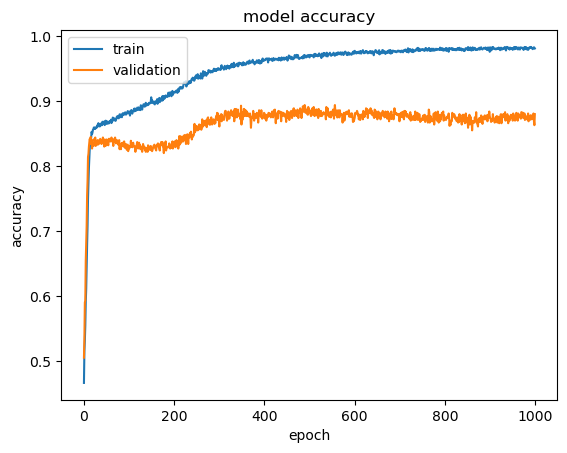

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [115]:
filename = 'chatbot_1000_epochs.h5'
model.save(filename)

In [88]:
#model.load_weights('chatbot_120_epochs.h5')

In [103]:
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 0s 14ms/step


In [104]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [105]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [106]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [107]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99999964


In [123]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [124]:
my_question = "Is the football in the garden ?"

In [125]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [126]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [127]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [128]:
pred_results = model.predict(([ my_story, my_ques]))

1/1 [==============================] - 0s 28ms/step


In [129]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9941859
